<a href="https://colab.research.google.com/github/PetchMa/CERN_2023/blob/main/ML_OF_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Filter with Neural Network Correction
#### Peter Ma | June 24th

### Introduction
Here we demonstrate the application of using Recurrent Neural Networks (RNN's) and Gates to correct for the Optimal Filter. First recall that the optimal filter has the following structure, where the $V_{t-j}$'s are the `ADC` inputs at time step $t-j$ and the $a_{j}$ are the $j$th optimial filter coefficent (OFC). We allow for a constant bias term if needed. Let the number of OFC's be $n$ and where $t$ is the time step

$$O_t = \left(\sum_{j}^n a_{\text{linear}} V_{t-j}\right) +b $$

Our proposed correction method is to have the following structure:
$$O_t = \sum_{j}^n a_{\text{linear}} V_{t-j} + \overbrace{\Gamma}^{\text{Gate}}  \cdot\underbrace{\mathcal{O}_j}_{\text{NN}} $$
$$\Gamma \in [0,1],\quad \mathcal{O}\in \mathbb{R}^n$$
#### Motivation
The Optimal Filter is still robust in certain regimes of input data. Let us make use of the already simple model and add on to it small corrections. We fill in these small corrections by $\mathcal{O}$ which we model as a recurrent neural network.

However, since we know that we don't care about the energy reconstruction __everywhere__ but rather we care about the energy reconstruction at peaks where there's high energy, we can selectively restrict the problem to just these special regimes. These regimes are controlled by the $\Gamma$ "gate" value by multiplying this correction term by 0 or 1. This gives us the structure we see in the equation above.

#### Algorithm

Let us fill in the missing blanks. We will work with a window size of $m$ with $n$ optimal filter coefficents.

1.  We let $\mathcal{O}$ take in $m > n$ samples of `ADC` data
2.  We compute Optimial Filter from the most recent values, this case we have $n$ coefficents so we take the $n$ most recent `ADC` data points and feed into the `OF` model. Note: We keep track of the most recent $m$ `OF` outputs in memory.
3.   We take the most recent $n$ `OF` outputs and feed them into the gate model

Let us formalize this more.
1.  Compute `OF`
$$O_t = \left(\sum_{j}^n a_{\text{linear}} V_{t-j}\right)$$
2.   Compute Gate, here we are using $O$ as the saved $m$ samples of $O_t$ (optimial filter output)
$$\Gamma_t = \Gamma(O), \quad \Gamma : \mathbb{R}^{m} \to \mathbb{R}$$
3.   Lastly we compute the Correction terms where $V_t\in \mathbb{R}^m$ is all the $m$ samples of the `ADC`  
$$\mathcal{O}_j = \mathcal{O}(V_t)_j,\quad \mathcal{O}: \mathbb{R}^{m} \to \mathbb{R}^n$$

Okay enough talk, lets just do this.


# Code Demonstration

## Imports
Here we import standard python machine learning models.

In [ ]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
import time

**Note:** Here we are setting the maximum window size $m$ to be `20`. THIS IS IMPORTANT, we do not want the exceed the depth that the data was generated such that it learns the frequency in which random data was injected.

In [ ]:
window_size = 20

## Loading Data
Here I load the data I was given, this is using the same dataset that Claire uses.

In [ ]:
import tarfile
file = tarfile.open('/content/drive/MyDrive/CERN/HEC_Samples.tar.gz')
file.extractall('./content/drive/MyDrive/CERN')
file.close()


pulse=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/pule_shape.txt')
adc=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/adc_out.txt')
signal=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/signal.txt')
pileup=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/pileup.txt')
wiener=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/wiener_out.txt')
of_coeff =np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/of_coeffs.txt')
of_out =np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/of_coeffs.txt')

## Classical Optimal Filter
Here we implement optimal filter using the coefficents given to us.

In [ ]:
def run_OF(adc, of_coeff):
    result = []
    n = len(of_coeff)
    adc = np.array(adc, dtype=np.float64)
    for i in tqdm(range(n,len(adc))):
        sum_i = np.sum([adc[i-j] * of_coeff[j] for j in range(n)], dtype=np.float64)
        result += [sum_i]
    return np.array(result, dtype=np.float64)

In [ ]:
of_pred = run_OF(adc, of_coeff=of_coeff )

100%|██████████| 999995/999995 [00:12<00:00, 78335.61it/s] 


Text(0.5, 1.0, 'Energy')

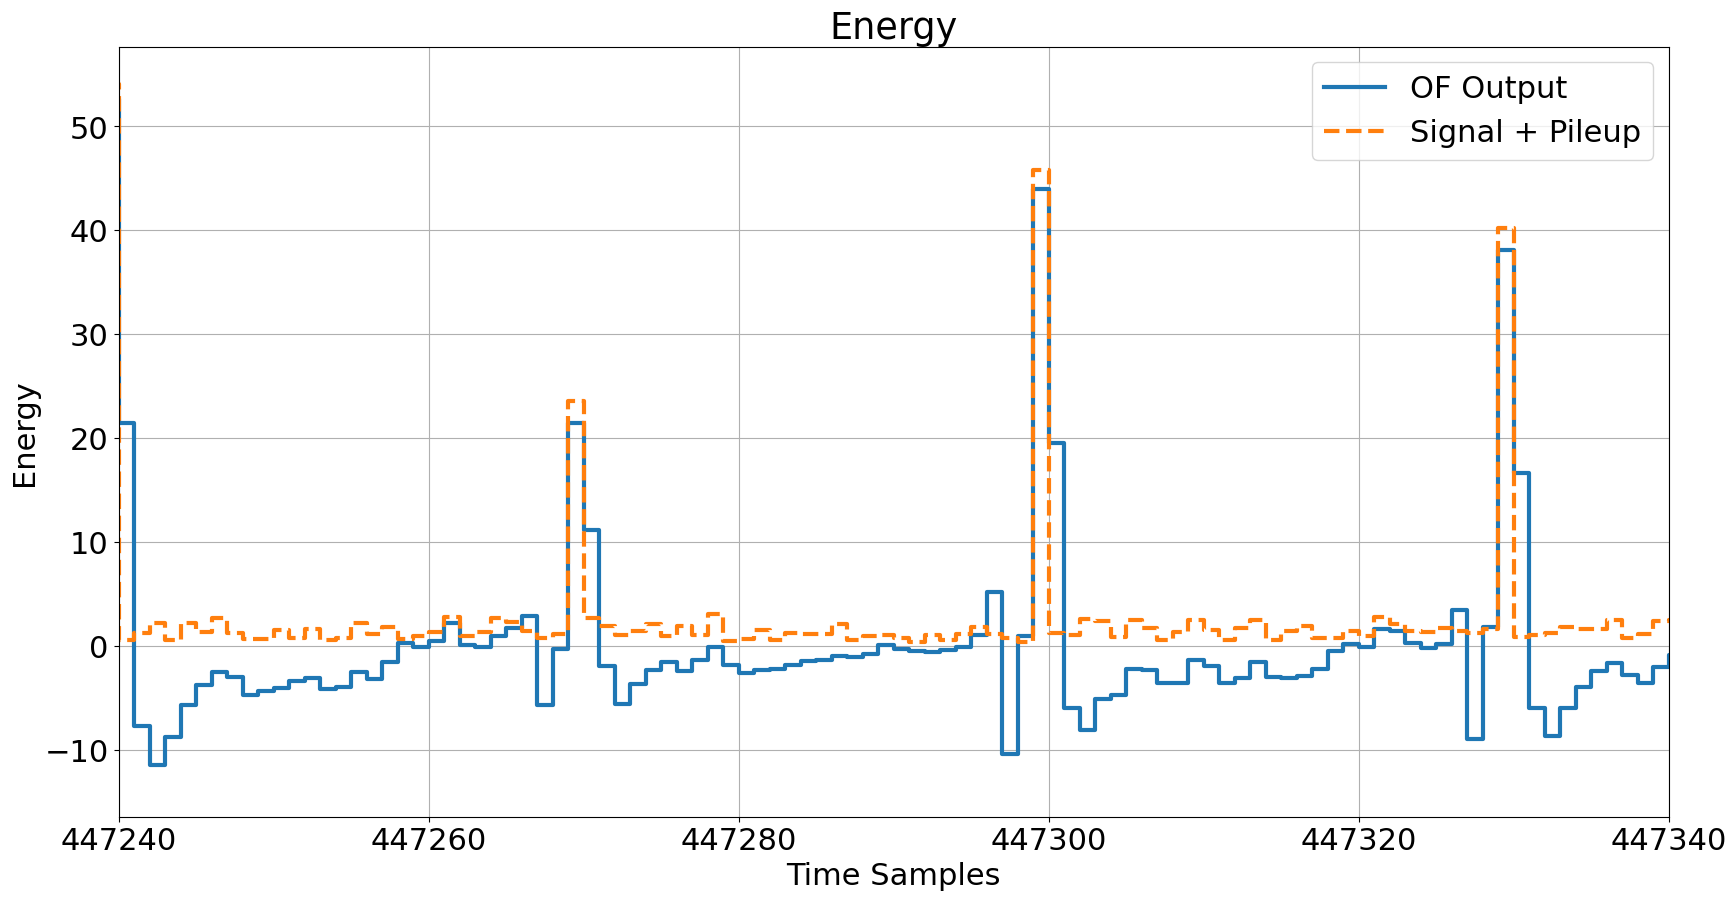

In [ ]:
# we pick a region where its interesting
ploting_index = np.argmax(of_pred)
# plot the data
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(20,10))

t = np.arange(0,of_pred.shape[0],1)
plt.step(t, of_pred, label='OF Output', linewidth = 3)

t = np.arange(0,signal.shape[0],1)
plt.step(t, pileup + signal, label='Signal + Pileup', linewidth = 3, linestyle='dashed')

plt.ylabel('Energy')
plt.xlabel('Time Samples')
plt.xlim(ploting_index, ploting_index+100 )
plt.legend()
plt.grid()
plt.title('Energy')

Okay the Optimal filter looks good. We see it struggle to match the correct energy deposited. We will try and mitigate this...

## Deep Learning Model
Here we begin constructing out deep learning algorithm for the correction term.

### Data Preprocessing
Here we split the data into two one being the FINAL testing data and the other being the training data

In [ ]:
percent_split = 0.2
test_split = int(percent_split* adc.shape[0])

# ADC Input data
adc_train = adc[test_split:]
adc_test = adc[:test_split]

# Signal + pileup
sig_pile_train = signal[test_split:] + pileup[test_split:]
sig_pile_test = signal[:test_split] + pileup[:test_split]

# pruely just the signal
sig_train, sig_test = signal[test_split:] , signal[:test_split]

print(adc_train.shape, adc_test.shape)
print(sig_pile_train.shape, sig_pile_test.shape)

(800000,) (200000,)
(799995,) (200000,)


#### Batching Training Samples
Here we just convert the `1-d` time series into multiple sliding windows stacked on each other to form a training samples.

In [ ]:
def prepare_data(adc, pile_signal, true_energy,  window_size = 5):
    input_data = []
    labels = []
    true_label = []
    for i in tqdm(range(1,adc.shape[0]-window_size)):
        input_data.append(adc[i  : i + window_size])
        labels.append(pile_signal[i-1])
        true_label.append(true_energy[i-1])
    return np.array(input_data), np.array(labels), np.array(true_label)

In [ ]:
dataset, labels, true_labels = prepare_data(adc_train, sig_pile_train, sig_train, window_size)
test_dataset, test_labels, test_true_labels = prepare_data(adc_test, sig_pile_test, sig_test, window_size)

print(dataset.shape, labels.shape)

100%|██████████| 199979/199979 [00:00<00:00, 1295934.27it/s]

(799979, 20) (799979,)


#### Training and Validation Split + Shuffle
Here we shuffle the data and split the training set further into a validation set and a training set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, y_true_train, y_true_test = train_test_split(dataset, labels, true_labels, test_size=0.2, random_state=12)
print(X_train.shape, y_train.shape)

(639983, 20) (639983,)


In [ ]:
max_adc = X_train.max()
print(max_adc)

52.460948


In [ ]:
# max_energy_val = y_train.max()
max_energy_val = 1
print(max_energy_val)

1


## Neural Network Model
Let us assume that the $\Gamma$ model perfectly selects the correct peak each time. This means that we can train things separately saving lots of pain in training two models coupled together...

Below is the model training structure. We are optimizing to minimize the variance of the __corrected optimial filter's__ error with the signal + pileup energy deposits.

In [ ]:
class New_OF_Model(keras.Model):
    def __init__(self, HOrder_model, OF_model, **kwargs):
        super(New_OF_Model, self).__init__(**kwargs)
        self.HOrder_model = HOrder_model
        self.OF_model = OF_model
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data
        OF_inputs = x[0]
        HOrder_inputs = x[1]
        with tf.GradientTape() as tape:
            HOrder_pred = self.HOrder_model(HOrder_inputs)
            pred = self.OF_model([OF_inputs, HOrder_pred])
            total_loss = tf.math.reduce_std( (y-pred))**2

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "total_loss": self.total_loss_tracker.result()
        }
    def test_step(self, data):
        x, y = data
        OF_inputs = x[0]
        HOrder_inputs = x[1]

        HOrder_pred = self.HOrder_model(HOrder_inputs)
        pred = self.OF_model([OF_inputs, HOrder_pred])
        total_loss = tf.math.reduce_std( (y-pred))**2

        self.total_loss_tracker.update_state(total_loss)
        return {
            "total_loss": self.total_loss_tracker.result()
        }
    def __call__(self, inputs):
        OF_inputs = inputs[0]
        HOrder_inputs = inputs[1]
        HOrder_pred = self.HOrder_model(HOrder_inputs)
        OF_pred = self.OF_model([OF_inputs, 0 ])
        pred = self.OF_model([OF_inputs, HOrder_pred])
        return pred

    def HO_prediction(self, inputs):
        OF_inputs = inputs[0]
        HOrder_inputs = inputs[1]

        HOrder_pred = self.HOrder_model(HOrder_inputs)
        return self.OF_model([OF_inputs, HOrder_pred])

    def pure_OF_prediction(self, inputs):
        return self.OF_model([inputs, 0])

### Custom Layers
Here we create custom layers for the optimal filter etc...

In [ ]:
class OF_last_layer(keras.layers.Layer):
    def __init__(self, OFC):
        super().__init__()
        self.w = OFC
    def call(self, inputs):
        return inputs * self.w

class Filter_layer(keras.layers.Layer):
    def __init__(self, max_energy_val):
        super().__init__()
        self.max_energy_val = max_energy_val
    def call(self, inputs):
        OF_val = inputs[0]
        HOrder = inputs[1]
        return tf.math.reduce_sum(OF_val +  self.max_energy_val * HOrder, axis=-1)

In [ ]:
from keras import layers
OF_inputs = keras.Input(shape=(5, ), name='Optimal Filter Input')
HOrder_inputs = keras.Input(shape=(window_size, 1 ), name='Higher Order Input')


HO_x = layers.SimpleRNN(10, activation='tanh', return_sequences = True)(HOrder_inputs)
HO_x = layers.SimpleRNN(10, activation='tanh', return_sequences = True)(HO_x)
HO_x = layers.SimpleRNN(10, activation='tanh', return_sequences = True)(HO_x)
HO_x = layers.SimpleRNN(10, activation='tanh', return_sequences = False)(HO_x)
HO_x = layers.Flatten()(HO_x)
HO_x = layers.Dense(10, activation="relu")(HO_x)
HO_x_out = layers.Dense(5, activation="linear")(HO_x)
HOrder_model = keras.Model( HOrder_inputs, HO_x_out)
HOrder_model.summary()



OF = OF_last_layer(of_coeff[::-1])(OF_inputs)
final_output = Filter_layer(max_energy_val)([OF, HO_x_out])
OF_model = keras.Model( [OF_inputs, HO_x_out], final_output)
OF_model.summary()

model = New_OF_Model(HOrder_model, OF_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Higher Order Input (InputLa  [(None, 20, 1)]          0         
 yer)                                                            
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 10)            120       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 10)            210       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 10)            210       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10)                210       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                             

In [ ]:
non_zero_index_train = np.nonzero(y_true_train)
non_zero_index_test = np.nonzero(y_true_test)

x_train_filtered = X_train[non_zero_index_train,:][0,:,:]
x_test_filtered = X_test[non_zero_index_test,:][0,:,:]

y_train_filtered = y_train[non_zero_index_train]
y_test_filtered = y_test[non_zero_index_test]
print(x_train_filtered.shape)

(21382, 20)


## Training Model
Notice that one of the inputs only includes the most recent $n$ samples.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', patience=20)

history_HO = model.fit(x = [x_train_filtered[:, :5], x_train_filtered[:,:]/max_adc],
                                    y= y_train_filtered, epochs=5000, batch_size=1000,
                                    validation_data=([x_test_filtered[:, :5], x_test_filtered[:,:]/max_adc ],
                                                     y_test_filtered),
                                    validation_batch_size=1000, callbacks=[callback])

Epoch 1/5000
22/22 [==============================] - 7s 134ms/step - total_loss: 0.2846 - val_total_loss: 0.2498
Epoch 2/5000
22/22 [==============================] - 2s 70ms/step - total_loss: 0.2432 - val_total_loss: 0.2343
Epoch 3/5000
22/22 [==============================] - 2s 75ms/step - total_loss: 0.2299 - val_total_loss: 0.2233
Epoch 4/5000
22/22 [==============================] - 3s 117ms/step - total_loss: 0.2211 - val_total_loss: 0.2138
Epoch 5/5000
22/22 [==============================] - 2s 89ms/step - total_loss: 0.2111 - val_total_loss: 0.2042
Epoch 6/5000
22/22 [==============================] - 2s 88ms/step - total_loss: 0.2019 - val_total_loss: 0.1957
Epoch 7/5000
22/22 [==============================] - 3s 141ms/step - total_loss: 0.1941 - val_total_loss: 0.1888
Epoch 8/5000
22/22 [==============================] - 2s 74ms/step - total_loss: 0.1881 - val_total_loss: 0.1833
Epoch 9/5000
22/22 [==============================] - 2s 68ms/step - total_loss: 0.1838 - val

# Check Bias Correction
Since we only trained this to correct the variance, it doesn't care about the mean. We check that the bias term has relatively no dependence on Energy dependence.

In [ ]:
predictions = model([x_train_filtered[:, :5], x_train_filtered[:,:]/max_adc]).numpy()
print(predictions.shape)
res = y_train_filtered - predictions
print(np.std(res))
print(np.mean(res))

(21382,)
0.32269622048633984
2.2397018444830397


In [ ]:
def find_index(data, top, bottom):
  ind = []
  for i in range(data.shape[0]):
    if top > data[i] > bottom:
      ind.append(i)
  return np.array(ind)


2.2385097075848432 0.025711446081067072


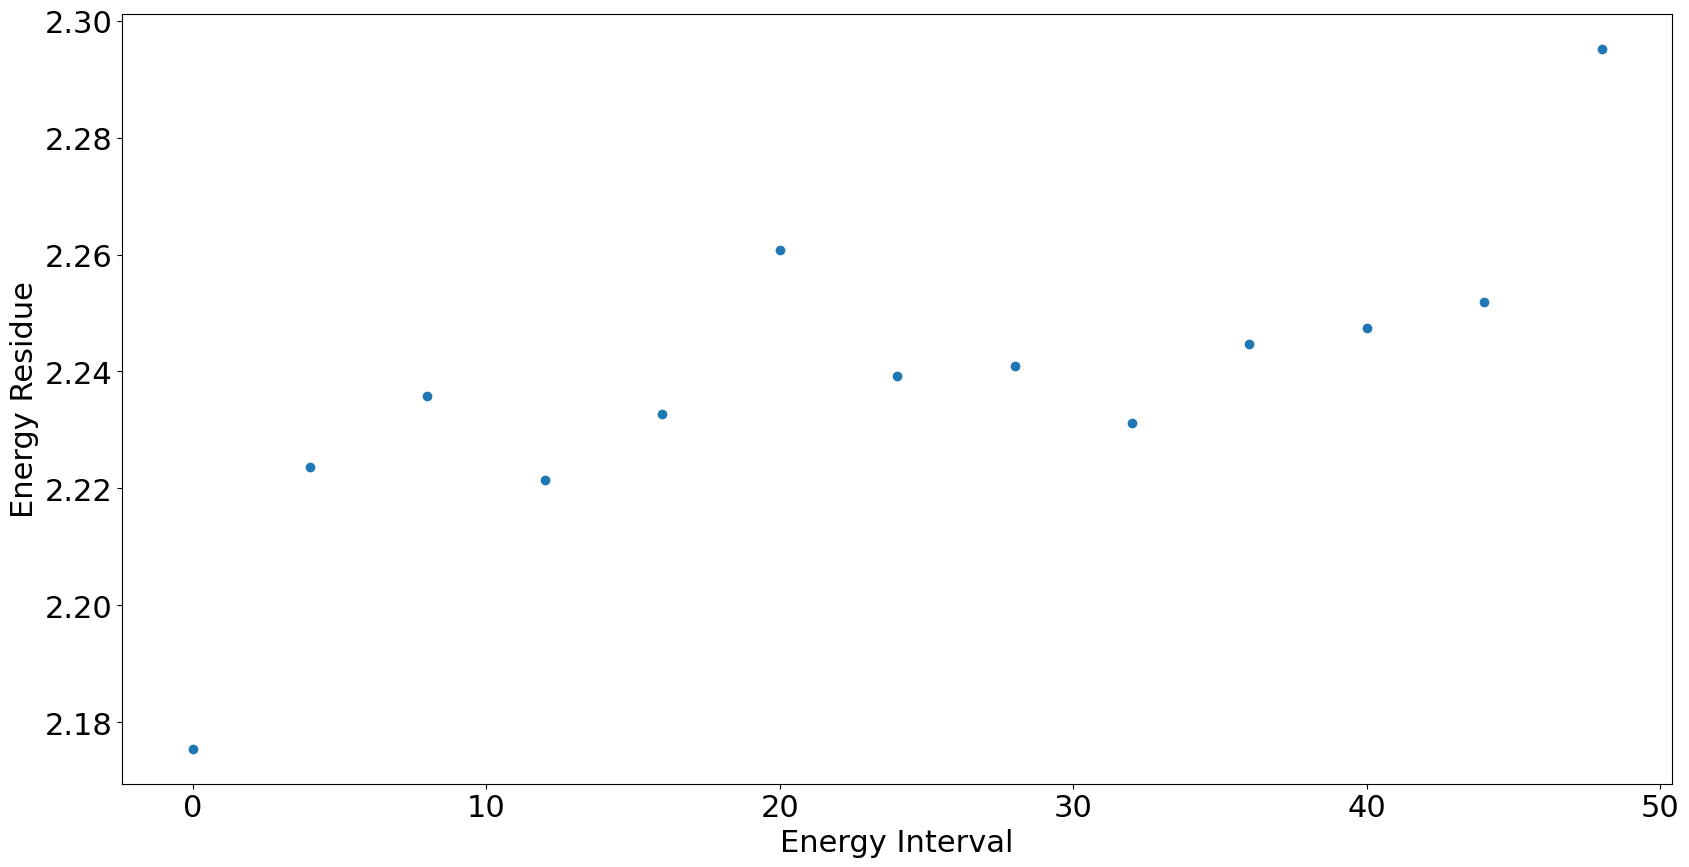

In [ ]:
interval = 4
index = np.arange(0,50, interval)

means = []
m = []
for el in index:
  ind_20_10 = find_index(y_train_filtered, el+interval, el)
  filtered = predictions[ind_20_10]
  expected = y_train_filtered[ind_20_10]
  res =  expected - filtered
  means.append(np.mean(res))



plt.figure(figsize=(20,10))
plt.scatter(index, means)
plt.xlabel('Energy Interval')
plt.ylabel('Energy Residue')
print(np.mean(means), np.std(means))
bias = np.mean(means)

*Note* We see that the mean residues has little dependence on time which means that we can subtract a constant bias term with no real problems.

# Implementing $\Gamma$ Gate function
So far we've shed of a lot of the responsibility to the $\Gamma$ function to be able to detect when a useful signal is coming through. To do so we implement the following gate function.

The idea is that if the `optimial` filter prediction passes a certain threshold (default is 2GeV) AND such that we have a peak, then we use the neural network correction. Else wise we let the optimal filter do its thing.

In [ ]:
def gate_function(of, thres = 2):
    if np.argmax(of) == 0 and of[0] > thres:
        return 1
    else:
        return 0

## All Together Now
We check how well this works with our dataset visually on the test set. This uses both the Optimal Filter, plus a Gate and a Neural Network Correction Term with the corrected constant bias in a "in sequence" manner.

In [ ]:
from numba import jit, prange

def optimal_nn_model(adc, bias, window_size = 20):
    OF_signal = []
    gate_signal = []
    HOrder_signal = []
    energy_reconstruction = []
    for i in tqdm(range(0, 1000)):
        # compute optimal filter
        OF_val = np.sum(adc[i:i+5] * of_coeff[::-1])
        OF_signal.append(OF_val)
        # get gate signal
        gate = gate_function(OF_signal[-window_size:][::-1], thres = 5)
        # preprocessing
        if gate == 1:
          sliced = adc[i:i+window_size]
          sliced = np.expand_dims(sliced, axis = 0)
          sliced = np.expand_dims(sliced, axis =-1)
          sliced = sliced / max_adc
          HOrder = HOrder_model(sliced).numpy()
        else:
          HOrder = 0
        gate_signal.append(gate)
        HOrder_signal.append(HOrder)
        energy_reconstruction.append(OF_val + gate * np.sum(HOrder) + gate * bias)
    return np.array(OF_signal), np.array(gate_signal), np.array(HOrder_signal), np.array(energy_reconstruction)

In [ ]:
# pick most interesting point
idx = np.argmax(adc_test)

OF, gate, HOrder, energy_reconstruction = optimal_nn_model(adc_test[idx: ], bias, window_size = 20)

100%|██████████| 1000/1000 [00:05<00:00, 173.78it/s]
<ipython-input-59-0e781bdee7d9>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(OF_signal), np.array(gate_signal), np.array(HOrder_signal), np.array(energy_reconstruction)


# Testing Model
### Visual Inspection
Here we visually inspect how well this reconstruction performed. as a sanity check


Text(0.5, 1.0, 'Energy')

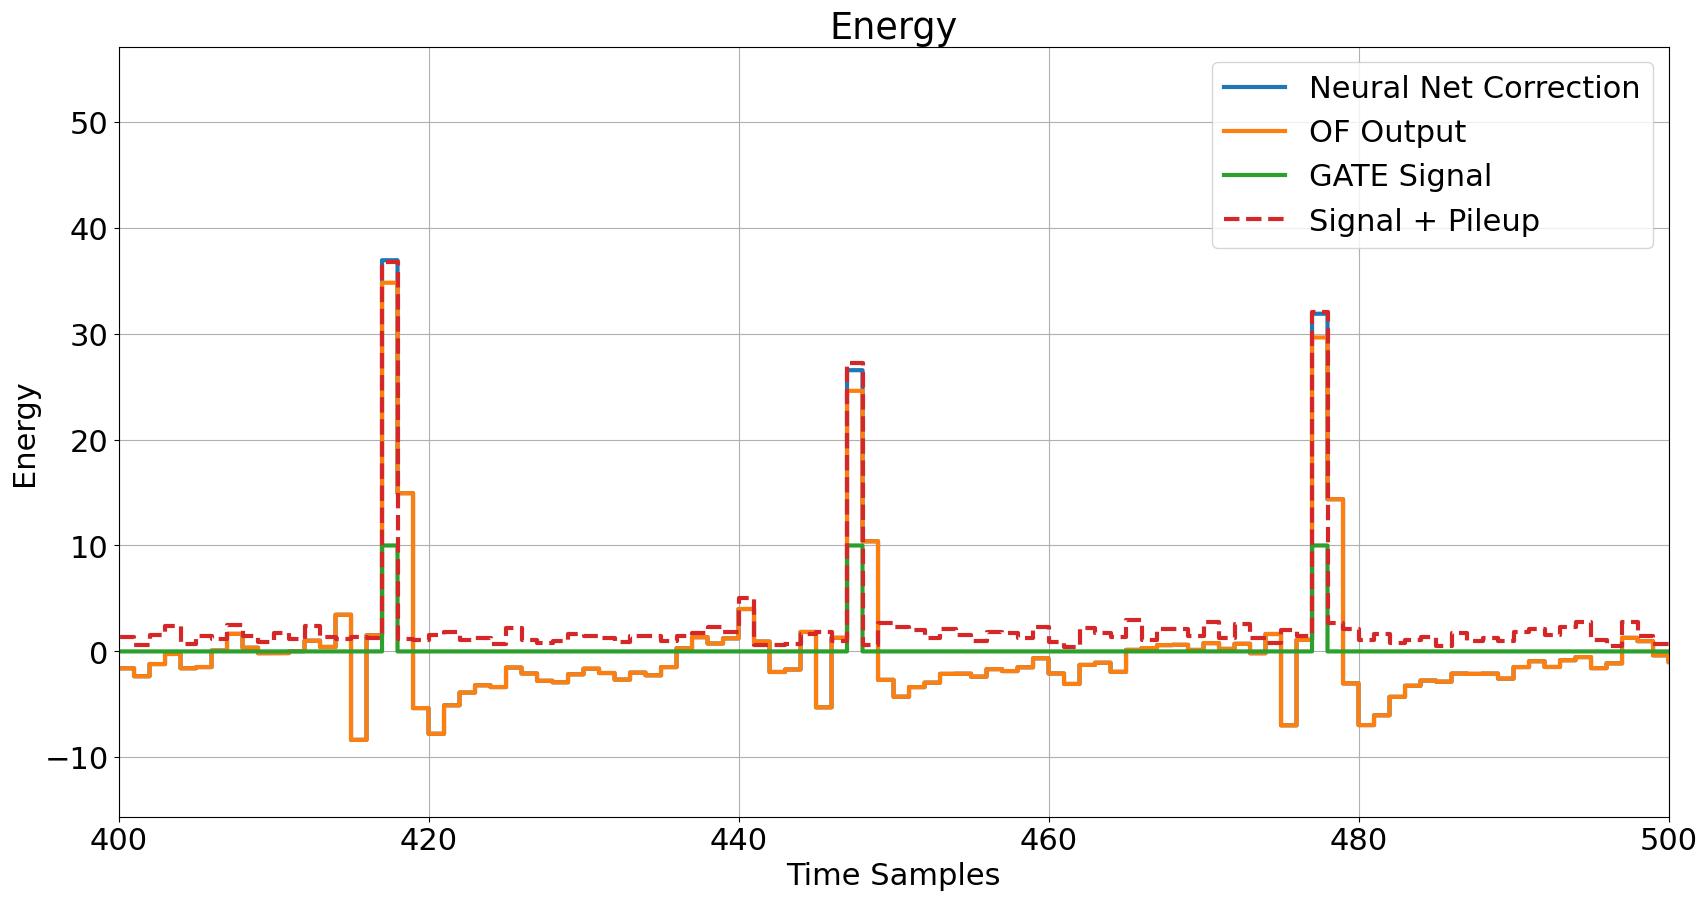

In [ ]:
ploting_index = np.argmax(energy_reconstruction)
# plot the data
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(20,10))

t = np.arange(0,energy_reconstruction.shape[0],1)
plt.step(t, energy_reconstruction, label='Neural Net Correction', linewidth = 3)

t = np.arange(0,OF.shape[0],1)
plt.step(t, OF, label='OF Output', linewidth = 3)

t = np.arange(0,gate.shape[0],1)
plt.step(t, gate*10, label='GATE Signal', linewidth = 3)

t = np.arange(1,sig_pile_test[idx:].shape[0] + 1,1)
plt.step(t, sig_pile_test[idx:], label='Signal + Pileup', linewidth = 3, linestyle='dashed')

plt.ylabel('Energy')
plt.xlabel('Time Samples')
plt.xlim(400, 500 )
plt.legend()
plt.grid()
plt.title('Energy')

# Energy Resolution Test
Here we test the energy resolution of the new correction model

In [ ]:
def batch_data(adc,  window_size = 5):
    input_data = []
    for i in tqdm(range(1,adc.shape[0]-window_size)):
        input_data.append(adc[i  : i + window_size])
    return np.array(input_data)

batched_test = batch_data(adc_test, window_size =window_size )
print(batched_test.shape)

100%|██████████| 199979/199979 [00:00<00:00, 1719610.55it/s]

(199979, 20)


In [ ]:
correction_output = model([batched_test[:, :5], batched_test[:,:]/max_adc]).numpy()
of_output =  model.pure_OF_prediction(batched_test[:, :5]).numpy()

Text(0.5, 0, 'error')

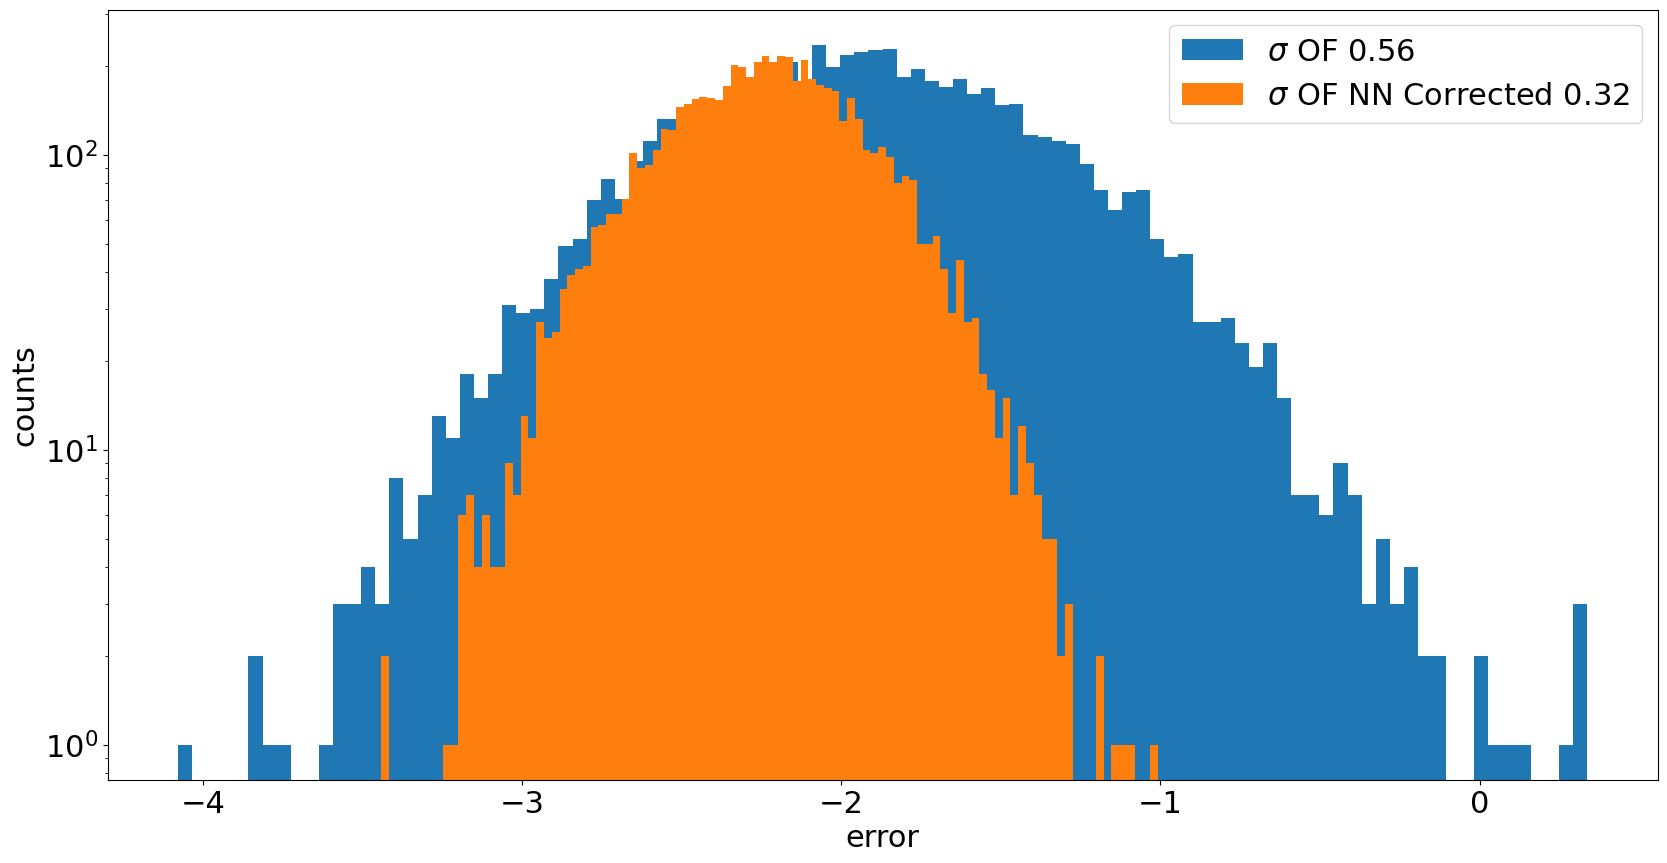

In [ ]:
index_filtered =  np.nonzero(sig_test)
index_filtered_list =  list(index_filtered[0])
index_filtered_list.remove(199980)
# get ride of the last index ()
filtered = correction_output[index_filtered_list]
filtered_of = of_output[index_filtered_list]

expected = sig_pile_test[index_filtered_list]

res = filtered -  expected
nn_sigma = np.std(res)

res_of = filtered_of -  expected
of_sigma = np.std(res_of)

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.hist(res_of, bins=100, label ='$\sigma$ OF ' +  str(round(of_sigma,2)))

plt.hist(res, bins=100, label ='$\sigma$ OF NN Corrected ' + str(round(nn_sigma, 2)))
plt.yscale('log')
plt.legend()
plt.ylabel('counts')
plt.xlabel('error')

Text(0, 0.5, '$\\sigma(E_T - E_{pred})$')

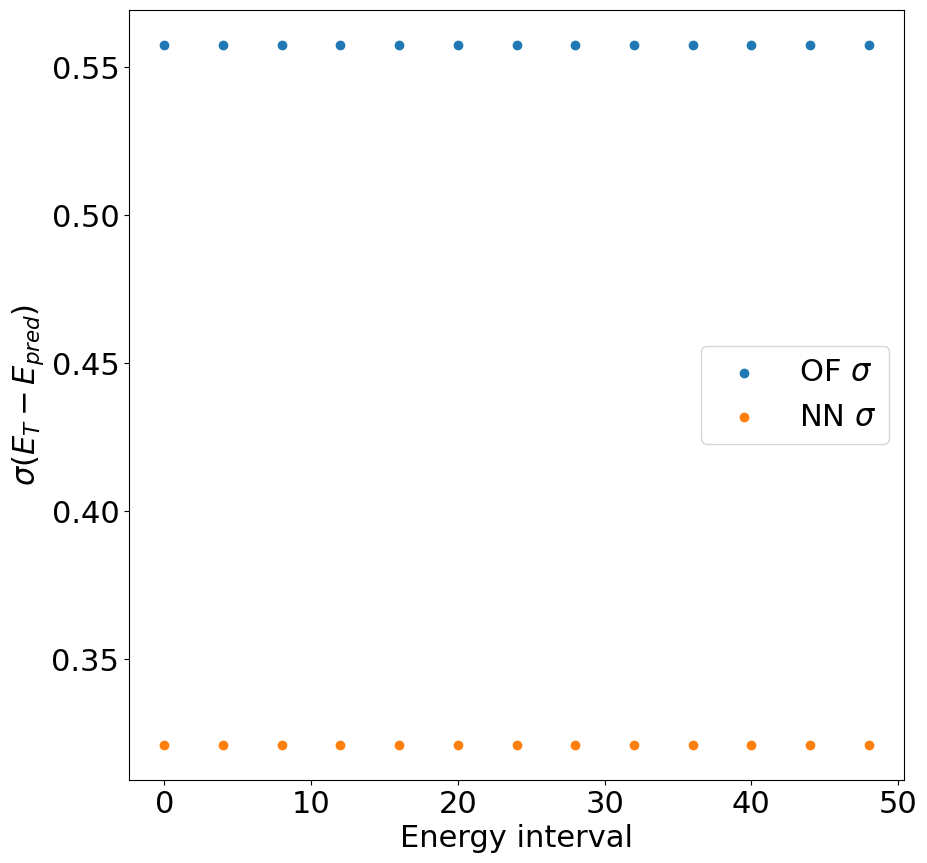

In [ ]:
interval = 4
index = np.arange(0,50, interval)

std_nn = []
std_of = []
e = []
for el in index:
  ind_20_10 = find_index(sig_test, el+interval, el)
  index_filtered_list =  list(index_filtered[0])
  index_filtered_list.remove(199980)
  filtered = correction_output[index_filtered_list]
  expected = sig_pile_test[index_filtered_list]
  res = filtered -  expected
  std_nn.append(np.std(res))

  filtered_of = of_pred[index_filtered_list]
  res_of = filtered_of -  expected
  std_of.append(np.std(res_of))

plt.figure(figsize=(10,10))
plt.scatter(index, std_of, label="OF $\sigma$")
plt.scatter(index, std_nn, label="NN $\sigma$")
plt.legend()
plt.xlabel('Energy interval')
plt.ylabel('$\sigma(E_T - E_{pred})$')

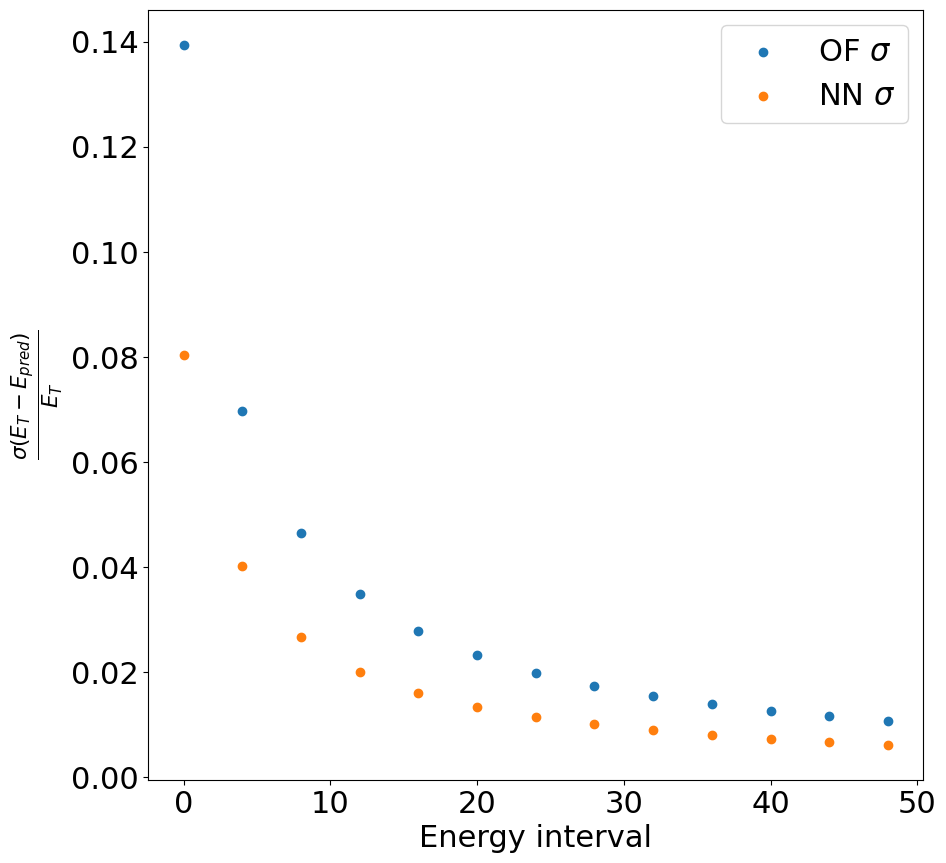

In [ ]:
interval = 4
index = np.arange(0,50, interval)

std_nn = []
std_of = []
e = []
for el in index:
  ind_20_10 = find_index(sig_test, el+interval, el)
  index_filtered_list =  list(index_filtered[0])
  index_filtered_list.remove(199980)
  filtered = correction_output[index_filtered_list]
  expected = sig_pile_test[index_filtered_list]
  res = filtered -  expected
  std_nn.append(np.std(res)/(el+interval))

  filtered_of = of_pred[index_filtered_list]
  res_of = filtered_of -  expected
  std_of.append(np.std(res_of)/(el+interval))

plt.figure(figsize=(10,10))
plt.scatter(index, std_of, label="OF $\sigma$")
plt.scatter(index, std_nn, label="NN $\sigma$")
plt.xlabel('Energy interval')
plt.ylabel('$\\frac{\sigma(E_T - E_{pred})}{E_{T}}$')
plt.legend()

# Checking Higher Order Fits - John Sievers Ideas
Below we implement a filter with nonlinear terms.

In [ ]:
pulse=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/pule_shape.txt')
adc=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/adc_out.txt')
signal=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/signal.txt')
pileup=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/pileup.txt')
wiener=np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/wiener_out.txt')
of_coeff =np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/of_coeffs.txt')
of_out =np.loadtxt('./content/drive/MyDrive/CERN/HEC_Samples/of_coeffs.txt')


percent_split = 0.2
test_split = int(percent_split* adc.shape[0])

# ADC Input data
adc_train = adc[test_split:]
adc_test = adc[:test_split]

# Signal + pileup
sig_pile_train = signal[test_split:] + pileup[test_split:]
sig_pile_test = signal[:test_split] + pileup[:test_split]

In [ ]:
print(pileup.shape,adc.shape )

(999995,) (1000000,)


In [ ]:
nleft=25  #how many samples to the left of our data point we are allowed to use
lag=8 #how many samples to the right of our sample we are allowed to use
nright=lag+1 #offset by 1 is because of python indexing
nn=nleft+nright+2
mat=np.zeros([len(adc_train),nn])
ncut=10000 #snip this many samples off the ends to avoid edge effects in simulations.
mm=np.zeros([len(adc_train)-2*ncut,nn])
for i in range(nn-1):
    mm[:,i]=adc_train[ncut-nleft+i:-ncut-nleft+i]
mm[:,-1]=1 #add a constant offset as a parameter, since samples were not zero mean

In [ ]:
mm_big=np.hstack([mm,mm[:,:-1]**2])[:-5]#let us use the square and the cube of the ADC samples
print(mm_big.shape)

(779995, 71)


# Solve Least Squares

In [ ]:
ss=sig_pile_train[ncut:-ncut]
lhs2=mm_big.T@mm_big
rhs2=mm_big.T@ss
coeffs2=np.linalg.inv(lhs2)@rhs2
pred2=mm_big@coeffs2
print('nonlinear rms is ',np.std((ss-pred2)[ncut:-ncut]))

nonlinear rms is  0.3896257514516877


# Applying Quadratic Fit


In [ ]:
def apply_filt_quadratic(adc,nleft,nright,coeffs):
    out=0*adc
    offset=coeffs[nleft+nright+1]
    linear=coeffs[:nleft+nright+1]
    quadratic=coeffs[nleft+nright+2:]
    for i in tqdm(range(nleft,len(adc)-nright-1)):
        tmp=offset
        for j in range(nleft+nright+1):
            val=adc[i-nleft+j]
            tmp=tmp+linear[j]*val+quadratic[j]*val**2
        out[i]=tmp
    return out

In [ ]:
nonlinear_energy_recon = apply_filt_quadratic(adc_test,nleft,nright,coeffs2)

100%|██████████| 199965/199965 [00:05<00:00, 36395.80it/s]


Text(0.5, 1.0, 'Energy')

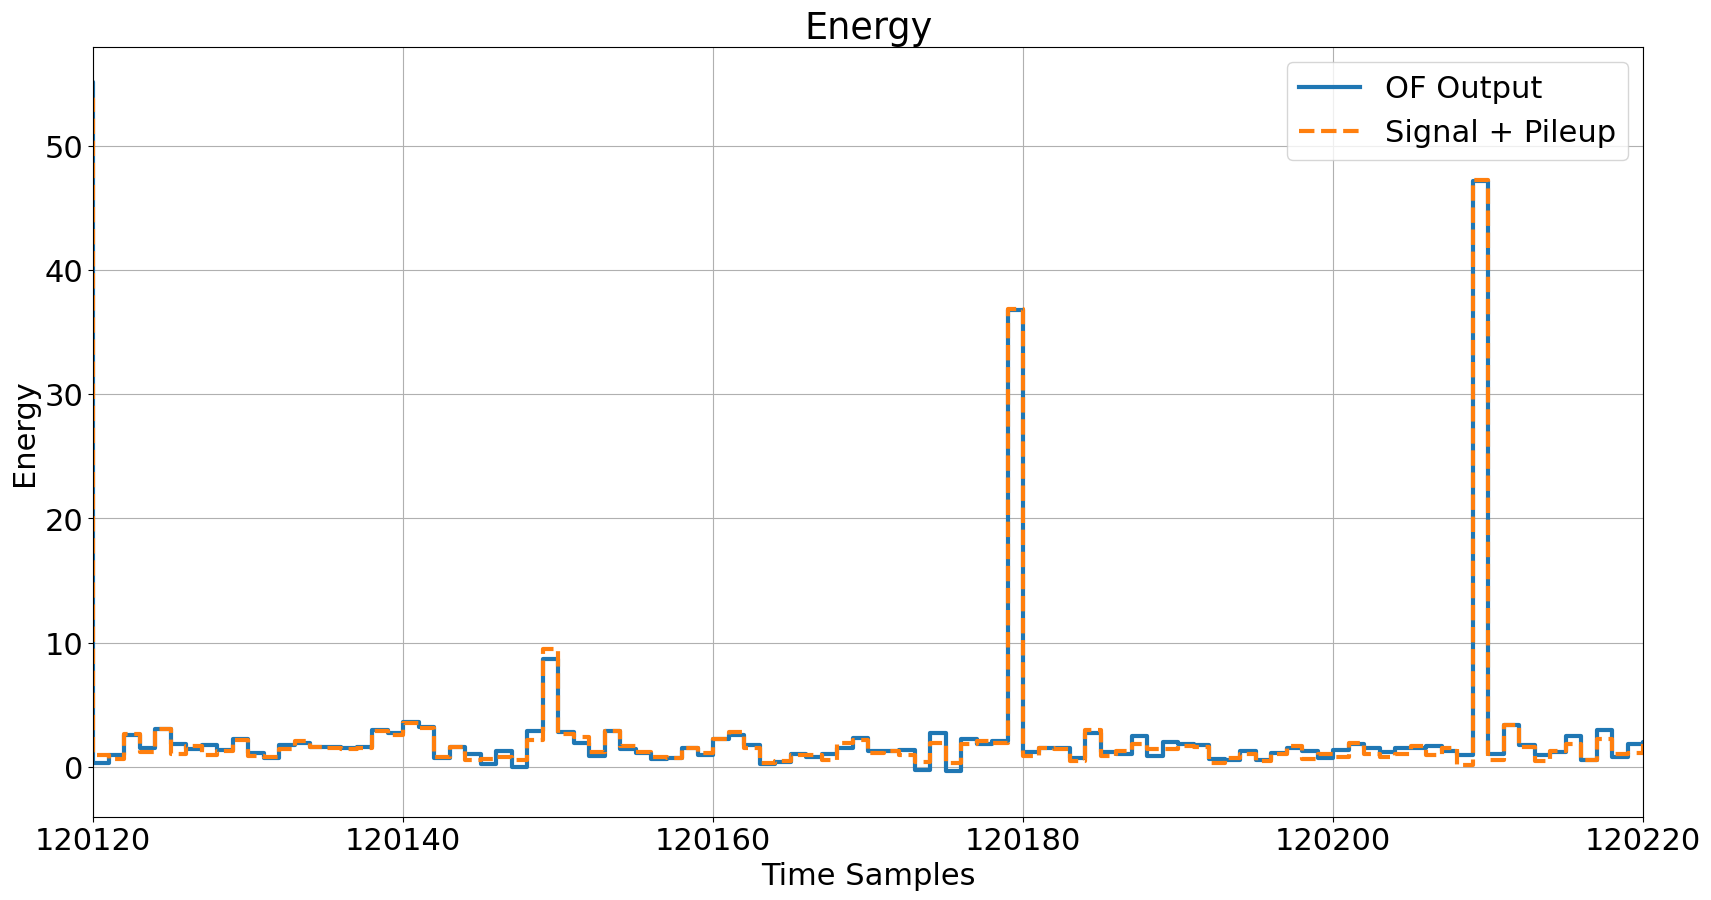

In [ ]:
ploting_index = np.argmax(nonlinear_energy_recon)
# plot the data
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(20,10))

t = np.arange(0,nonlinear_energy_recon.shape[0],1)
plt.step(t, nonlinear_energy_recon, label='OF Output', linewidth = 3)

t = np.arange(0,sig_pile_test.shape[0],1)
plt.step(t, sig_pile_test, label='Signal + Pileup', linewidth = 3, linestyle='dashed')

plt.ylabel('Energy')
plt.xlabel('Time Samples')
plt.xlim(ploting_index, ploting_index+100 )
plt.legend()
plt.grid()
plt.title('Energy')

# Errors of Peaks

Text(0.5, 0, 'error')

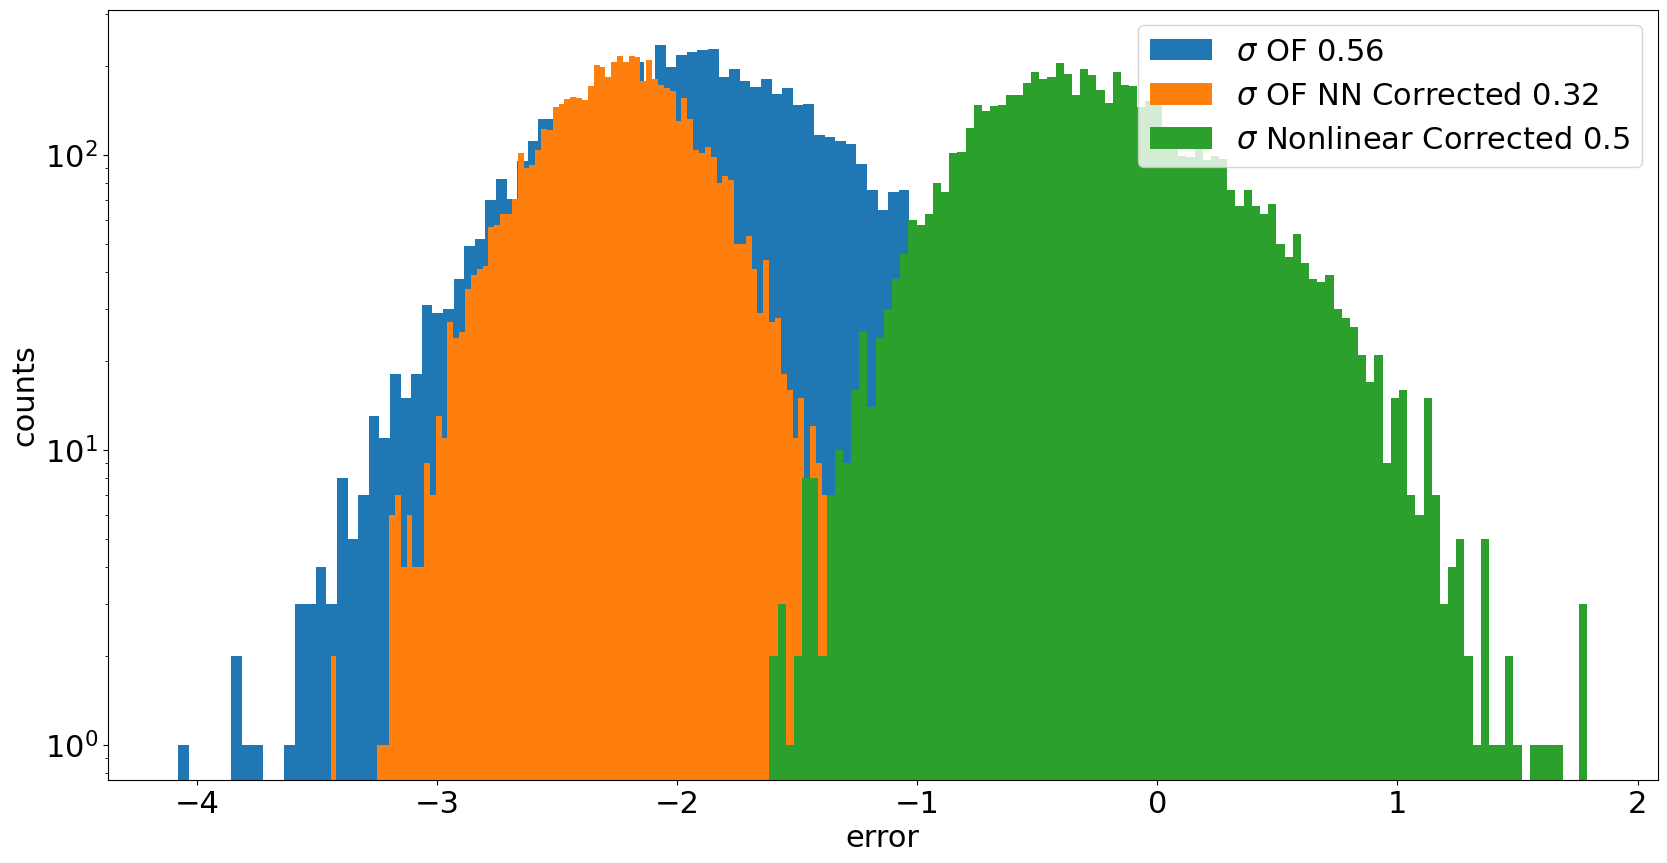

In [ ]:
index_filtered =  np.nonzero(sig_test)
index_filtered_list =  list(index_filtered[0])
index_filtered_list.remove(199980)
# get ride of the last index ()
filtered = correction_output[index_filtered_list]
filtered_of = of_output[index_filtered_list]
filtered_nonlinear = nonlinear_energy_recon[index_filtered_list]

expected = sig_pile_test[index_filtered_list]

res = filtered - expected
nn_sigma = np.std(res)

res_of = filtered_of -  expected
of_sigma = np.std(res_of)

res_nonlinear = filtered_nonlinear -  expected
nonlinear_sigma = np.std(res_nonlinear)

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.hist(res_of, bins=100, label ='$\sigma$ OF ' +  str(round(of_sigma,2)))

plt.hist(res, bins=100, label ='$\sigma$ OF NN Corrected ' + str(round(nn_sigma, 2)))
plt.hist(res_nonlinear, bins=100, label ='$\sigma$ Nonlinear Corrected ' + str(round(nonlinear_sigma, 2)))

plt.yscale('log')
plt.legend()
plt.ylabel('counts')
plt.xlabel('error')

# Total Errors Nonlinear


In [ ]:
print('nonlinear rms is ',np.std((sig_pile_test-nonlinear_energy_recon)[ncut:-ncut]))

nonlinear rms is  0.38887907405598976
